## ARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

#### Declare some visual functions

In [2]:
def plot_actual_vs_predicted(X_validation, y_actual, y_pred, feature, xlabel, ylabel):
    """
    Draw a scatter plot comparing actual and predicted values for a specific feature.

    Parameters:
    X_validation (pd.DataFrame): Input data containing the feature to be plotted.
    y_actual (array-like): Actual value.
    y_pred (array-like): Predicted value.
    feature (str): Column name in X_validation to compare.
    xlabel (str): Label for the X-axis (name of the feature displayed on the chart).
    ylabel (str): Label for the Y-axis (e.g. Price, Area, ...).
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(X_validation[feature], y_actual, c='r', marker='o', label="Actual values", alpha=0.5) 
    plt.scatter(X_validation[feature], y_pred, c='b', marker='s', label="Predicted values", alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(f"Scatter Plot of Actual vs Predicted {ylabel} per {xlabel}")
    plt.show()


#### Select feature

##### Read data

- Practice training

In [3]:
df = pd.read_csv("TransformedData.csv")
df.head()

,Posted Time,District Name,Price per m2
0,2024-12-01,Huyện Hòa Vang,0.103732
1,2024-12-02,Huyện Hòa Vang,0.103732
2,2024-12-03,Huyện Hòa Vang,0.103732
3,2024-12-04,Huyện Hòa Vang,0.103732
4,2024-12-05,Huyện Hòa Vang,0.103227


##### Input variables

In [4]:
if not pd.api.types.is_datetime64_any_dtype(df['Posted Time']):
    df['Posted Time'] = pd.to_datetime(df['Posted Time'])
districts = df['District Name'].unique()
print(f"Các quận/huyện trong dữ liệu: {districts}")

Các quận/huyện trong dữ liệu: ['Huyện Hòa Vang' 'Quận Cẩm Lệ' 'Quận Hải Châu' 'Quận Liên Chiểu'
 'Quận Ngũ Hành Sơn' 'Quận Sơn Trà' 'Quận Thanh Khê']


##### Target variables

In [5]:
# Bước 4: Chia dữ liệu thành tập huấn luyện và tập kiểm tra cho từng quận
def split_train_test(data, test_size=0.2):
    # Dictionary lưu trữ dữ liệu đã chia của các quận
    district_data = {}
    
    for district in districts:
        # Lọc dữ liệu cho quận cụ thể
        district_df = data[data['District Name'] == district].copy()
        
        # Sắp xếp dữ liệu theo thời gian
        district_df = district_df.sort_values('Posted Time')
        
        # Chuẩn bị chuỗi thời gian
        time_series = district_df.set_index('Posted Time')['Price per m2']
        
        # Chia dữ liệu thành tập train và test
        train_size = int(len(time_series) * (1 - test_size))
        train_ts = time_series[:train_size]
        test_ts = time_series[train_size:]
        
        # Lưu vào dictionary
        district_data[district] = {
            'full_ts': time_series,
            'train_ts': train_ts,
            'test_ts': test_ts,
            'train_raw': district_df.iloc[:train_size],
            'test_raw': district_df.iloc[train_size:]
        }
    
    return district_data

##### Divide into 2 training sets and validation sets

 - Split data

In [6]:
# Bước 5: Thực hiện chia dữ liệu
district_datasets = split_train_test(df, test_size=0.2)

In [7]:
# Bước 6: Hàm kiểm tra tính dừng của chuỗi thời gian (stationarity)
def check_stationarity(time_series, district):
    """
    Kiểm tra tính dừng của chuỗi thời gian bằng Augmented Dickey-Fuller test
    
    Parameters:
    time_series (Series): Chuỗi thời gian cần kiểm tra
    district (str): Tên quận
    
    Returns:
    dict: Kết quả kiểm tra
    """
    # Thực hiện ADF test
    result = adfuller(time_series.dropna())
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(time_series)
    plt.title(f'Chuỗi thời gian giá bất động sản tại {district}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá (đơn vị/m2)')
    plt.grid(True)
    plt.show()
    
    # Rolling statistics
    plt.figure(figsize=(12, 6))
    rolling_mean = time_series.rolling(window=7).mean()
    rolling_std = time_series.rolling(window=7).std()
    
    plt.plot(time_series, label='Dữ liệu gốc')
    plt.plot(rolling_mean, label='Trung bình trượt (7 ngày)')
    plt.plot(rolling_std, label='Độ lệch chuẩn trượt (7 ngày)')
    plt.legend()
    plt.title(f'Phân tích trượt cho chuỗi thời gian tại {district}')
    plt.grid(True)
    plt.show()
    
    # ADF test results
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    
    if result[1] <= 0.05:
        print("Chuỗi thời gian đã dừng (stationary)")
        diff_order = 0
    else:
        print("Chuỗi thời gian chưa dừng (non-stationary)")
        diff_order = 1  # Đề xuất sử dụng d=1 cho ARIMA
    
    return {
        'adf_statistic': result[0],
        'p_value': result[1],
        'diff_order': diff_order
    }

In [8]:
# Bước 7: Xác định thông số ARIMA cho từng quận
def determine_arima_params(district, time_series):
    """
    Xác định các thông số cho mô hình ARIMA
    
    Parameters:
    district (str): Tên quận
    time_series (Series): Chuỗi thời gian
    
    Returns:
    tuple: Các tham số (p, d, q) cho ARIMA
    """
    print(f"Xác định thông số ARIMA cho {district}")
    
    # Kiểm tra tính dừng
    stationarity_check = check_stationarity(time_series, district)
    d = stationarity_check['diff_order']
    
    # Nếu chuỗi không dừng, thực hiện phép sai phân (differencing)
    if d > 0:
        time_series_diff = time_series.diff(d).dropna()
        print(f"Đã thực hiện sai phân bậc {d}")
        
        # Kiểm tra lại tính dừng sau khi sai phân
        diff_stationarity = check_stationarity(time_series_diff, f"{district} (sau sai phân)")
    else:
        time_series_diff = time_series
    
    # Vẽ đồ thị ACF và PACF để xác định p, q
    plt.figure(figsize=(12, 8))
    
    plt.subplot(211)
    plot_acf(time_series_diff.dropna(), ax=plt.gca(), lags=20)
    plt.title(f'ACF cho {district}')
    
    plt.subplot(212)
    plot_pacf(time_series_diff.dropna(), ax=plt.gca(), lags=20)
    plt.title(f'PACF cho {district}')
    
    plt.tight_layout()
    plt.show()
    
    # Xác định p, q dựa trên ACF và PACF
    # Đây là một cách đơn giản để ước lượng, có thể dùng phương pháp lưới hoặc AIC/BIC để tối ưu
    p = int(input(f"Nhập giá trị p cho {district} (thường là số lag có ý nghĩa trong PACF): "))
    q = int(input(f"Nhập giá trị q cho {district} (thường là số lag có ý nghĩa trong ACF): "))
    
    return (p, d, q)

#### Model training

In [9]:
# Bước 8: Tự động tìm tham số ARIMA tốt nhất
def auto_arima_params(district, time_series, max_p=5, max_d=2, max_q=5):
    """
    Tự động tìm tham số ARIMA tốt nhất dựa trên AIC
    
    Parameters:
    district (str): Tên quận
    time_series (Series): Chuỗi thời gian
    max_p, max_d, max_q (int): Giá trị tối đa cho p, d, q
    
    Returns:
    tuple: Các tham số (p, d, q) tốt nhất cho ARIMA
    """
    print(f"Đang tìm tham số ARIMA tối ưu cho {district}...")
    
    # Kiểm tra tính dừng để xác định d
    stationarity_check = check_stationarity(time_series, district)
    best_d = stationarity_check['diff_order']
    
    best_aic = float('inf')
    best_params = None
    
    # Tìm kiếm lưới qua các tham số p, q
    # Note: Quá trình này có thể mất nhiều thời gian, chúng ta sẽ giới hạn phạm vi tìm kiếm
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(time_series, order=(p, best_d, q))
                results = model.fit()
                
                # Nếu AIC thấp hơn, cập nhật tham số tốt nhất
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (p, best_d, q)
                    
                    print(f"Tìm thấy mô hình tốt hơn: ARIMA{best_params} với AIC = {best_aic}")
            except:
                continue
    
    print(f"Tham số ARIMA tốt nhất cho {district}: {best_params}")
    return best_params

##### Correlation Coefficient and Intercept Deviation Value

In [10]:
# Bước 9: Huấn luyện mô hình ARIMA cho từng quận
def train_arima_models(district_datasets):
    """
    Huấn luyện mô hình ARIMA cho từng quận
    
    Parameters:
    district_datasets (dict): Dictionary chứa dữ liệu của các quận
    
    Returns:
    dict: Dictionary chứa các mô hình ARIMA đã huấn luyện và tham số
    """
    models = {}
    
    for district, datasets in district_datasets.items():
        print(f"\nĐang huấn luyện mô hình cho {district}...")
        
        # Lấy dữ liệu huấn luyện
        train_ts = datasets['train_ts']
        
        # Xác định tham số tự động
        order = auto_arima_params(district, train_ts)
        
        # Huấn luyện mô hình
        try:
            model = ARIMA(train_ts, order=order)
            results = model.fit()
            
            models[district] = {
                'order': order,
                'model': results
            }
            
            print(f"Mô hình ARIMA cho {district} đã được huấn luyện thành công!")
            print(f"Tham số: {order}")
            print(f"AIC: {results.aic}")
        except Exception as e:
            print(f"Lỗi khi huấn luyện mô hình cho {district}: {e}")
            # Thử với tham số mặc định nếu có lỗi
            try:
                default_order = (1, 1, 1)
                model = ARIMA(train_ts, order=default_order)
                results = model.fit()
                
                models[district] = {
                    'order': default_order,
                    'model': results
                }
                
                print(f"Sử dụng tham số mặc định ARIMA{default_order}")
            except:
                print(f"Không thể huấn luyện mô hình cho {district}")
    
    return models

##### Real estate price prediction

- On the train set


Đang huấn luyện mô hình cho Huyện Hòa Vang...
Đang tìm tham số ARIMA tối ưu cho Huyện Hòa Vang...


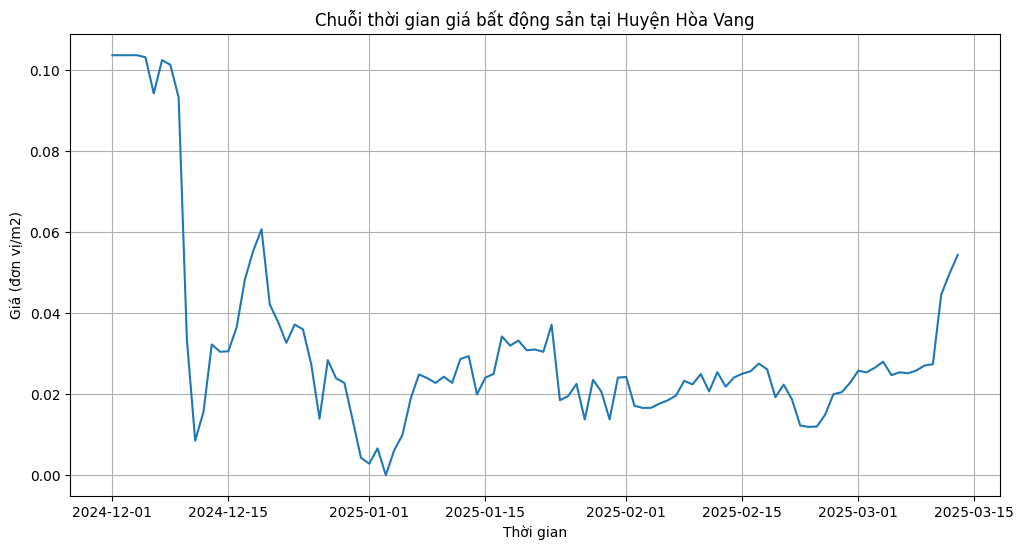

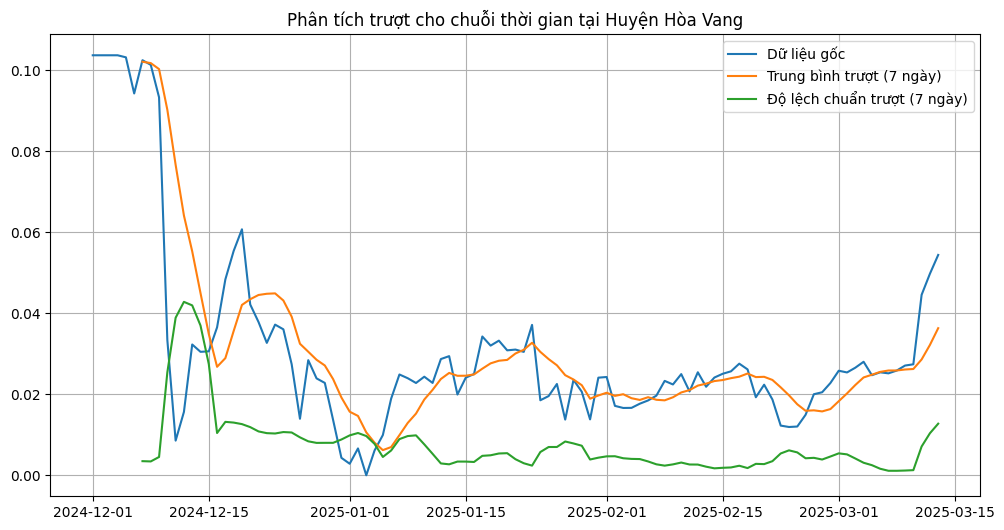

ADF Statistic: -2.301380793346319
p-value: 0.17152302491655297
Critical Value (1%): -3.506057133647011
Critical Value (5%): -2.8946066061911946
Critical Value (10%): -2.5844100201994697
Chuỗi thời gian chưa dừng (non-stationary)
Tìm thấy mô hình tốt hơn: ARIMA(0, 1, 0) với AIC = -673.3673972327128
Tìm thấy mô hình tốt hơn: ARIMA(0, 1, 1) với AIC = -676.655716559471
Tìm thấy mô hình tốt hơn: ARIMA(3, 1, 4) với AIC = -676.9830011130323
Tham số ARIMA tốt nhất cho Huyện Hòa Vang: (3, 1, 4)
Mô hình ARIMA cho Huyện Hòa Vang đã được huấn luyện thành công!
Tham số: (3, 1, 4)
AIC: -676.9830011130323

Đang huấn luyện mô hình cho Quận Cẩm Lệ...
Đang tìm tham số ARIMA tối ưu cho Quận Cẩm Lệ...


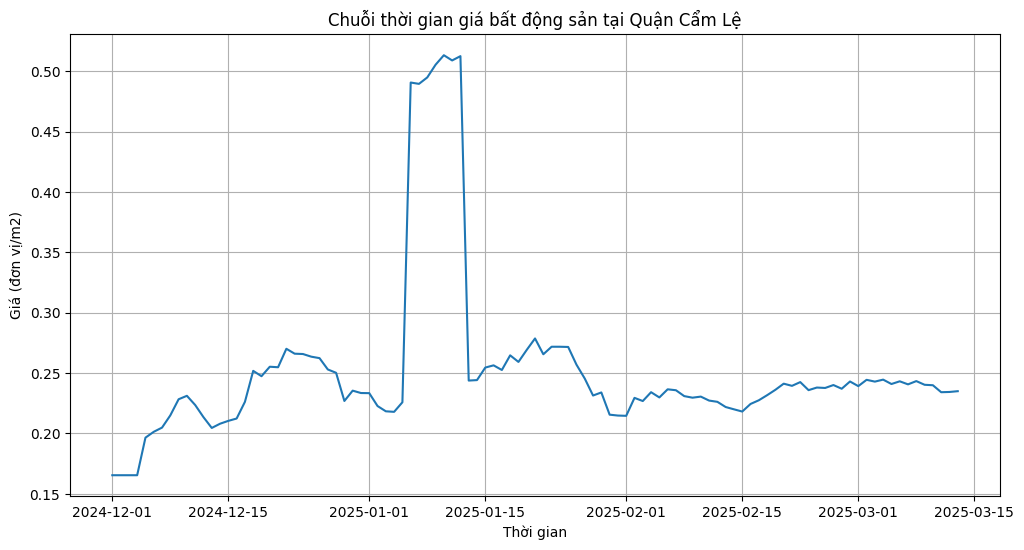

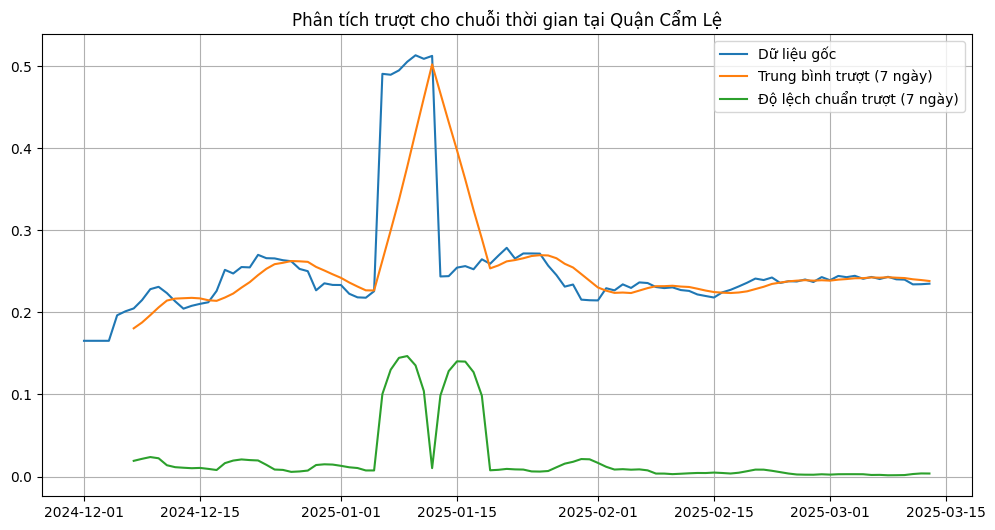

ADF Statistic: -2.2388913402111137
p-value: 0.1924340420068517
Critical Value (1%): -3.5011373281819504
Critical Value (5%): -2.8924800524857854
Critical Value (10%): -2.5832749307479226
Chuỗi thời gian chưa dừng (non-stationary)
Tìm thấy mô hình tốt hơn: ARIMA(0, 1, 0) với AIC = -374.7029509252876
Tìm thấy mô hình tốt hơn: ARIMA(2, 1, 5) với AIC = -374.83292512146767
Tìm thấy mô hình tốt hơn: ARIMA(3, 1, 4) với AIC = -378.09214013121107
Tìm thấy mô hình tốt hơn: ARIMA(4, 1, 5) với AIC = -380.05729892657723
Tham số ARIMA tốt nhất cho Quận Cẩm Lệ: (4, 1, 5)
Mô hình ARIMA cho Quận Cẩm Lệ đã được huấn luyện thành công!
Tham số: (4, 1, 5)
AIC: -380.05729892657723

Đang huấn luyện mô hình cho Quận Hải Châu...
Đang tìm tham số ARIMA tối ưu cho Quận Hải Châu...


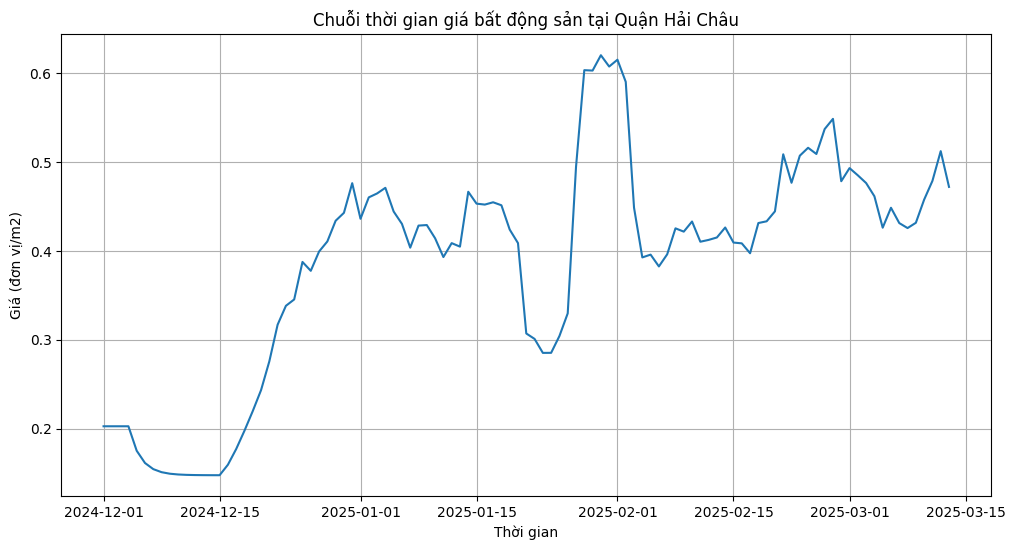

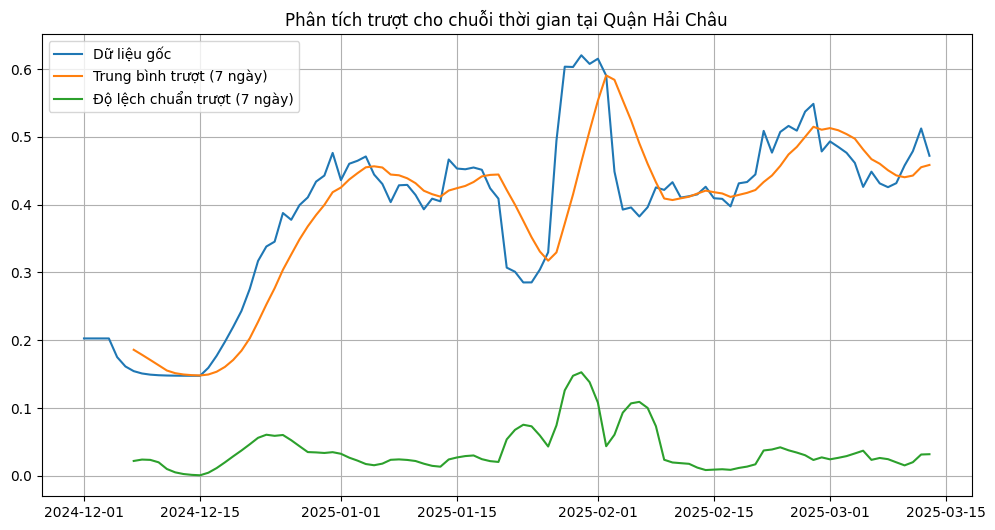

ADF Statistic: -2.134970199364671
p-value: 0.23068731638642104
Critical Value (1%): -3.5019123847798657
Critical Value (5%): -2.892815255482889
Critical Value (10%): -2.583453861475781
Chuỗi thời gian chưa dừng (non-stationary)
Tìm thấy mô hình tốt hơn: ARIMA(0, 1, 0) với AIC = -398.0538134396808
Tìm thấy mô hình tốt hơn: ARIMA(0, 1, 1) với AIC = -402.8925451196072
Tìm thấy mô hình tốt hơn: ARIMA(0, 1, 2) với AIC = -403.4256749342611
Tìm thấy mô hình tốt hơn: ARIMA(0, 1, 5) với AIC = -413.62474511495844
Tìm thấy mô hình tốt hơn: ARIMA(2, 1, 5) với AIC = -424.0637278614387
Tham số ARIMA tốt nhất cho Quận Hải Châu: (2, 1, 5)
Mô hình ARIMA cho Quận Hải Châu đã được huấn luyện thành công!
Tham số: (2, 1, 5)
AIC: -424.0637278614387

Đang huấn luyện mô hình cho Quận Liên Chiểu...
Đang tìm tham số ARIMA tối ưu cho Quận Liên Chiểu...


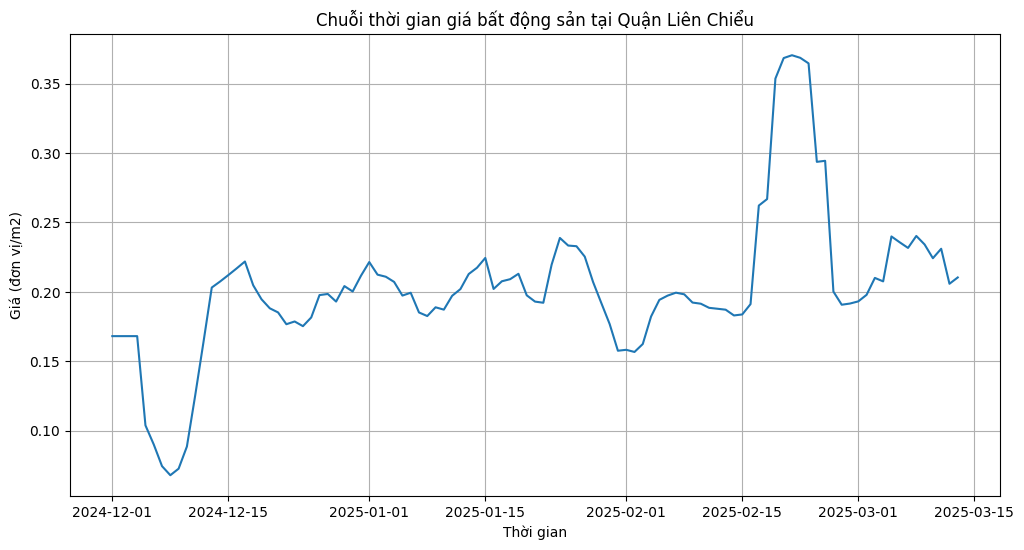

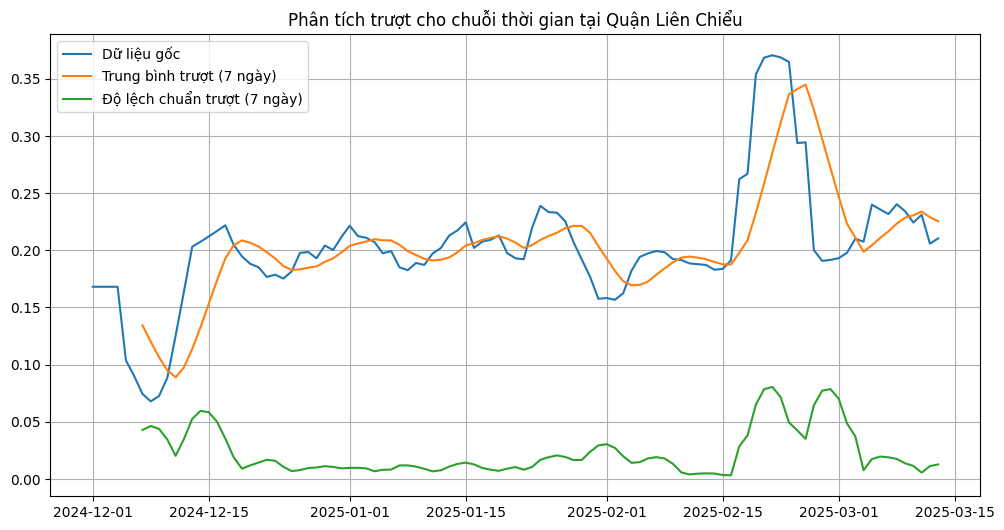

ADF Statistic: -2.9290514831443177
p-value: 0.042072506340540335
Critical Value (1%): -3.502704609582561
Critical Value (5%): -2.8931578098779522
Critical Value (10%): -2.583636712914788
Chuỗi thời gian đã dừng (stationary)
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 0) với AIC = -310.3391411706339
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 1) với AIC = -394.5832559822931
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 2) với AIC = -446.53288363352004
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 3) với AIC = -509.02665733894787
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 4) với AIC = -522.4693328329193
Tìm thấy mô hình tốt hơn: ARIMA(1, 0, 2) với AIC = -538.8999540637165
Tìm thấy mô hình tốt hơn: ARIMA(1, 0, 5) với AIC = -545.1189636496405
Tìm thấy mô hình tốt hơn: ARIMA(2, 0, 5) với AIC = -555.175292057227
Tham số ARIMA tốt nhất cho Quận Liên Chiểu: (2, 0, 5)
Mô hình ARIMA cho Quận Liên Chiểu đã được huấn luyện thành công!
Tham số: (2, 0, 5)
AIC: -555.175292057227

Đang huấn luyện mô hình cho Quận Ngũ Hành Sơn...
Đang

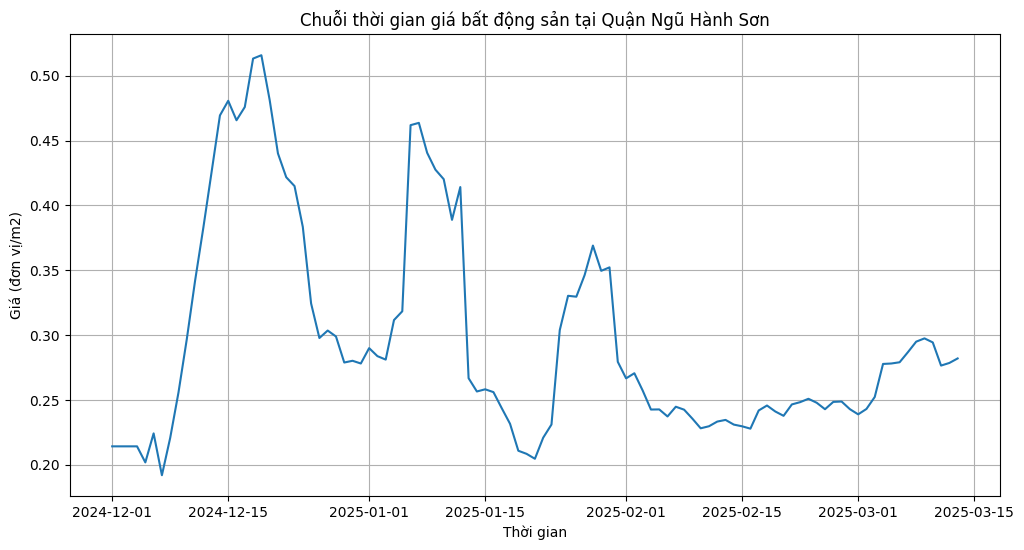

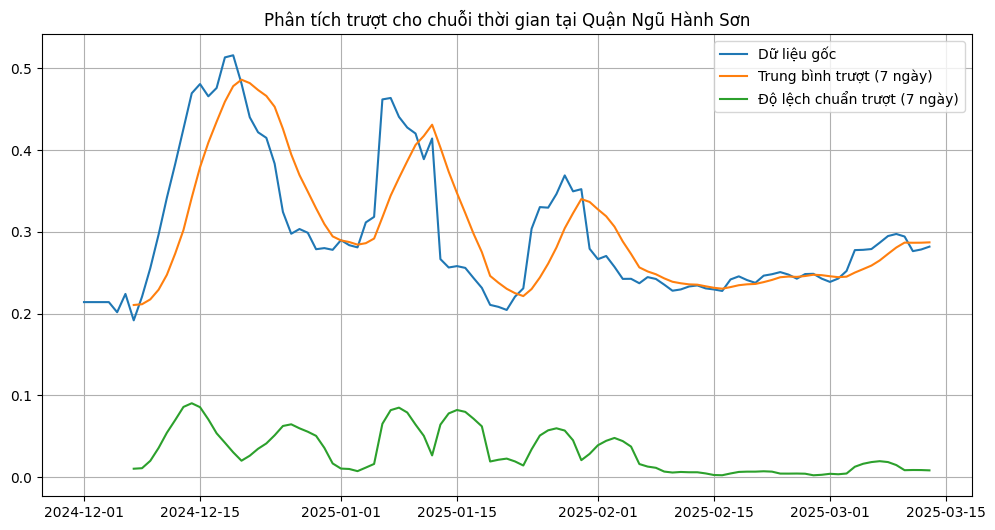

ADF Statistic: -2.453546287927239
p-value: 0.12718986680344802
Critical Value (1%): -3.5011373281819504
Critical Value (5%): -2.8924800524857854
Critical Value (10%): -2.5832749307479226
Chuỗi thời gian chưa dừng (non-stationary)
Tìm thấy mô hình tốt hơn: ARIMA(0, 1, 0) với AIC = -430.8086781243216
Tìm thấy mô hình tốt hơn: ARIMA(0, 1, 1) với AIC = -431.98996706082556
Tìm thấy mô hình tốt hơn: ARIMA(0, 1, 2) với AIC = -432.89601932096537
Tìm thấy mô hình tốt hơn: ARIMA(0, 1, 5) với AIC = -444.23080444223956
Tìm thấy mô hình tốt hơn: ARIMA(2, 1, 5) với AIC = -451.44927339097916
Tham số ARIMA tốt nhất cho Quận Ngũ Hành Sơn: (2, 1, 5)
Mô hình ARIMA cho Quận Ngũ Hành Sơn đã được huấn luyện thành công!
Tham số: (2, 1, 5)
AIC: -451.44927339097916

Đang huấn luyện mô hình cho Quận Sơn Trà...
Đang tìm tham số ARIMA tối ưu cho Quận Sơn Trà...


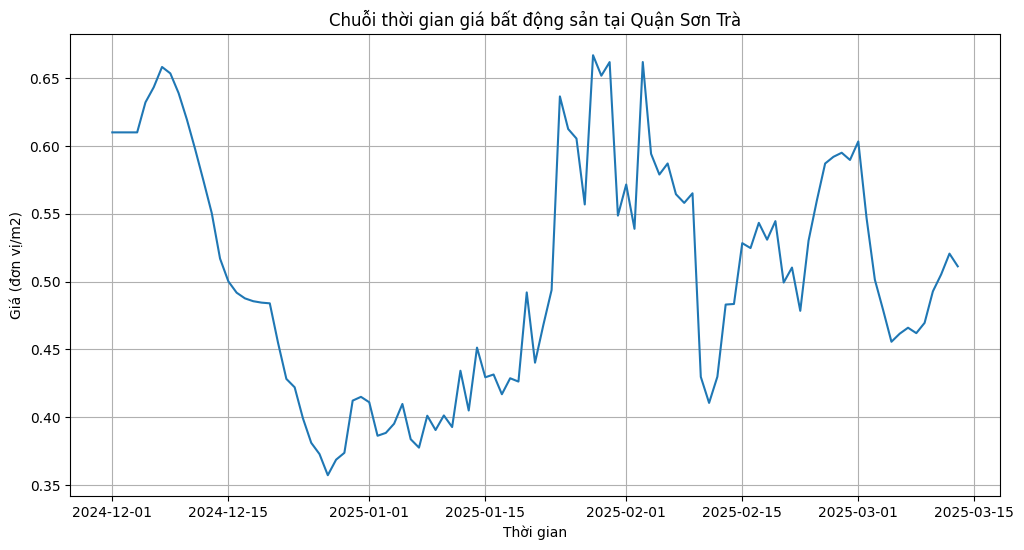

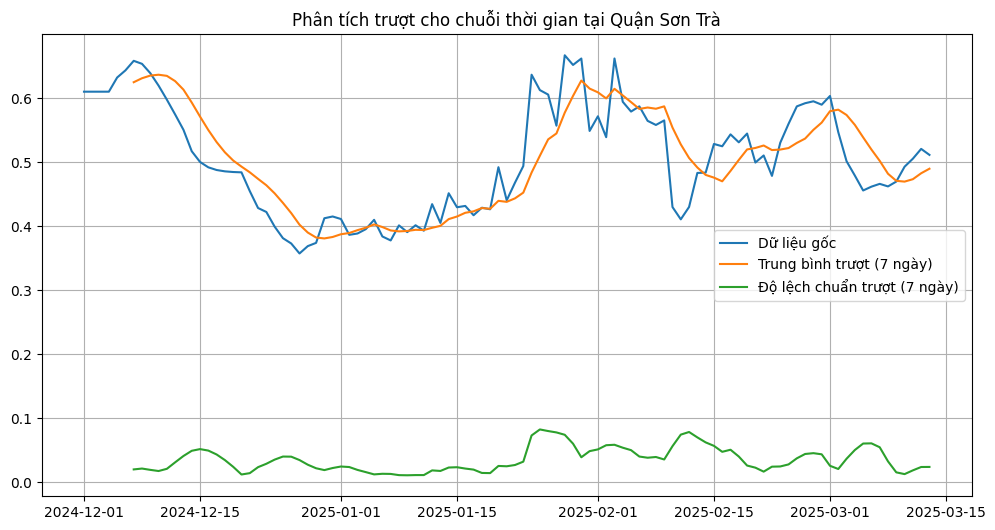

ADF Statistic: -3.208854702822903
p-value: 0.0194778215100536
Critical Value (1%): -3.505190196159122
Critical Value (5%): -2.894232085048011
Critical Value (10%): -2.5842101234567902
Chuỗi thời gian đã dừng (stationary)
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 0) với AIC = -210.11576898313066
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 1) với AIC = -278.25713262147167
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 2) với AIC = -345.0630432203662
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 3) với AIC = -363.7852956950213
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 4) với AIC = -374.48416502531137
Tìm thấy mô hình tốt hơn: ARIMA(1, 0, 0) với AIC = -386.9847309898756
Tìm thấy mô hình tốt hơn: ARIMA(1, 0, 2) với AIC = -387.14394748348764
Tìm thấy mô hình tốt hơn: ARIMA(1, 0, 3) với AIC = -392.8323819931434
Tìm thấy mô hình tốt hơn: ARIMA(1, 0, 4) với AIC = -399.9588394397804
Tìm thấy mô hình tốt hơn: ARIMA(1, 0, 5) với AIC = -400.27356959517795
Tìm thấy mô hình tốt hơn: ARIMA(2, 0, 1) với AIC = -403.6021739721336
Tìm 

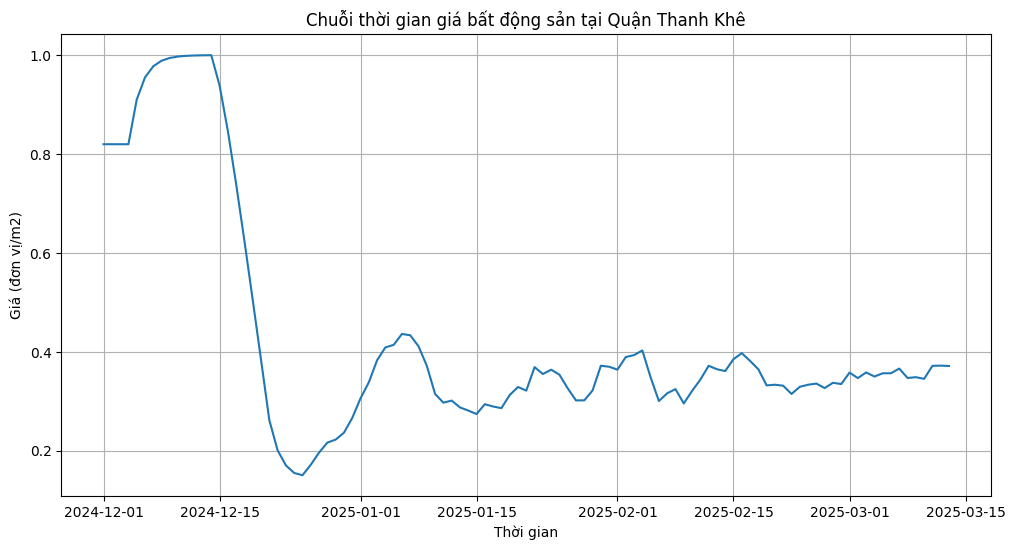

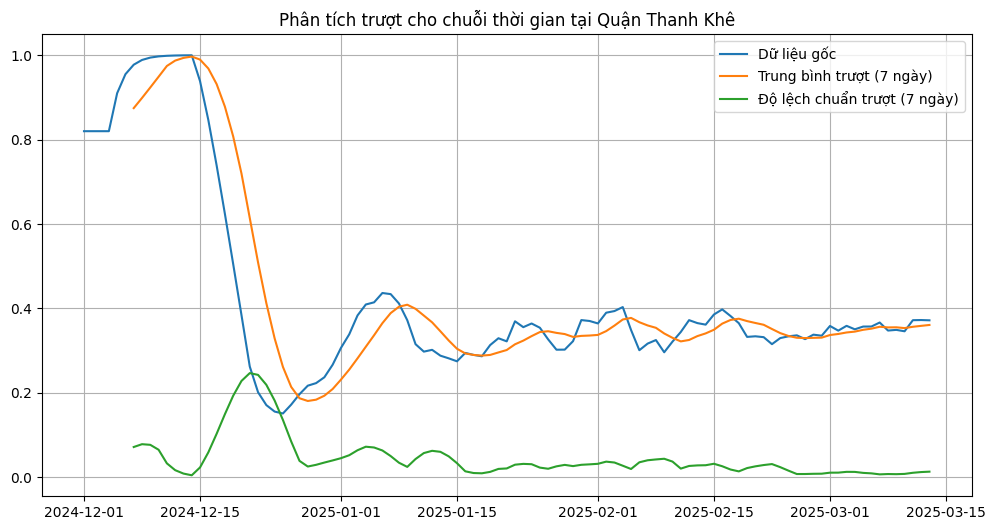

ADF Statistic: -3.554252506813919
p-value: 0.0066983167902945565
Critical Value (1%): -3.5019123847798657
Critical Value (5%): -2.892815255482889
Critical Value (10%): -2.583453861475781
Chuỗi thời gian đã dừng (stationary)
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 0) với AIC = -7.059341702223728
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 1) với AIC = -136.07098308495586
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 2) với AIC = -250.49261354817838
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 3) với AIC = -306.828118900202
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 4) với AIC = -379.0695579423321
Tìm thấy mô hình tốt hơn: ARIMA(0, 0, 5) với AIC = -382.8075018666908
Tìm thấy mô hình tốt hơn: ARIMA(1, 0, 1) với AIC = -428.03928112646713
Tìm thấy mô hình tốt hơn: ARIMA(1, 0, 2) với AIC = -444.83844938734876
Tìm thấy mô hình tốt hơn: ARIMA(1, 0, 3) với AIC = -449.9816920963573
Tìm thấy mô hình tốt hơn: ARIMA(1, 0, 4) với AIC = -457.5174161963217
Tìm thấy mô hình tốt hơn: ARIMA(1, 0, 5) với AIC = -458.03763310240316
Tì

In [11]:
district_models = train_arima_models(district_datasets)

In [12]:
# Bước 11: Đánh giá mô hình
def evaluate_arima_model(district, model_info, datasets, forecast_steps=180):
    """
    Đánh giá mô hình ARIMA và thực hiện dự báo
    
    Parameters:
    district (str): Tên quận
    model_info (dict): Thông tin về mô hình ARIMA
    datasets (dict): Dữ liệu của quận
    forecast_steps (int): Số bước dự báo trong tương lai
    
    Returns:
    dict: Kết quả đánh giá và dự báo
    """
    # Lấy dữ liệu và mô hình
    train_ts = datasets['train_ts']
    test_ts = datasets['test_ts']
    model_results = model_info['model']
    
    # Dự báo trên tập test
    if not test_ts.empty:
        # Dự báo trong sample
        in_sample_pred = model_results.predict(start=0, end=len(train_ts)-1)
        
        # Dự báo ngoài sample (tập test)
        test_forecast = model_results.forecast(steps=len(test_ts))
        
        # Tính các chỉ số đánh giá
        test_actual = test_ts.values
        test_predicted = test_forecast
        
        # Cắt test_predicted nếu dài hơn test_actual
        if len(test_predicted) > len(test_actual):
            test_predicted = test_predicted[:len(test_actual)]
        
        # Cắt test_actual nếu dài hơn test_predicted
        if len(test_actual) > len(test_predicted):
            test_actual = test_actual[:len(test_predicted)]
        
        mae = np.mean(np.abs(test_actual - test_predicted))
        mse = np.mean((test_actual - test_predicted) ** 2)
        rmse = np.sqrt(mse)
    else:
        in_sample_pred = model_results.predict(start=0, end=len(train_ts)-1)
        test_forecast = None
        mae = mse = rmse = np.nan
    
    # Dự báo trong tương lai
    future_forecast = model_results.forecast(steps=forecast_steps)
    
    # Tạo index cho dự báo tương lai
    if not test_ts.empty:
        last_date = test_ts.index[-1]
    else:
        last_date = train_ts.index[-1]
    
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)
    future_forecast_series = pd.Series(future_forecast, index=future_dates)
    
    return {
        'district': district,
        'in_sample_pred': in_sample_pred,
        'test_forecast': test_forecast,
        'test_metrics': {
            'mae': mae,
            'mse': mse,
            'rmse': rmse
        },
        'future_forecast': future_forecast_series
    }

In [13]:
# Bước 12: Thực hiện đánh giá và dự báo cho từng quận
evaluation_results = {}
for district, model_info in district_models.items():
    result = evaluate_arima_model(district, model_info, district_datasets[district])
    evaluation_results[district] = result

In [14]:
# Bước 13: Vẽ biểu đồ dự báo cho từng quận
def plot_district_forecast(district, eval_result, datasets):
    """
    Vẽ biểu đồ dự báo giá cho một quận cụ thể
    
    Parameters:
    district (str): Tên quận
    eval_result (dict): Kết quả đánh giá và dự báo
    datasets (dict): Dữ liệu của quận
    """
    train_ts = datasets['train_ts']
    test_ts = datasets['test_ts']
    in_sample_pred = eval_result['in_sample_pred']
    test_forecast = eval_result['test_forecast']
    future_forecast = eval_result['future_forecast']
    
    # Vẽ biểu đồ
    plt.figure(figsize=(14, 8))
    
    # Vẽ dữ liệu huấn luyện
    plt.plot(train_ts.index, train_ts.values, color='black', label='Dữ liệu huấn luyện')
    
    # Vẽ dự báo trong sample
    plt.plot(train_ts.index, in_sample_pred, color='blue', linestyle='--', label='Dự báo trong sample')
    
    # Vẽ dữ liệu kiểm tra nếu có
    if test_ts is not None and not test_ts.empty:
        plt.plot(test_ts.index, test_ts.values, color='red', label='Dữ liệu kiểm tra')
        
        # Vẽ dự báo trên tập test
        if test_forecast is not None:
            plt.plot(test_ts.index[:len(test_forecast)], test_forecast, color='green', 
                    linestyle='--', label='Dự báo ngoài sample')
    
    # Vẽ dự báo tương lai
    plt.plot(future_forecast.index, future_forecast.values, color='purple', 
             linestyle='--', label='Dự báo tương lai')
    
    # Thông tin về chỉ số đánh giá
    metrics = eval_result['test_metrics']
    metrics_text = f"MAE: {metrics['mae']:.4f}, RMSE: {metrics['rmse']:.4f}"
    
    plt.title(f'Dự báo giá bất động sản tại {district} sử dụng ARIMA\n{metrics_text}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá (đơn vị/m2)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    return plt

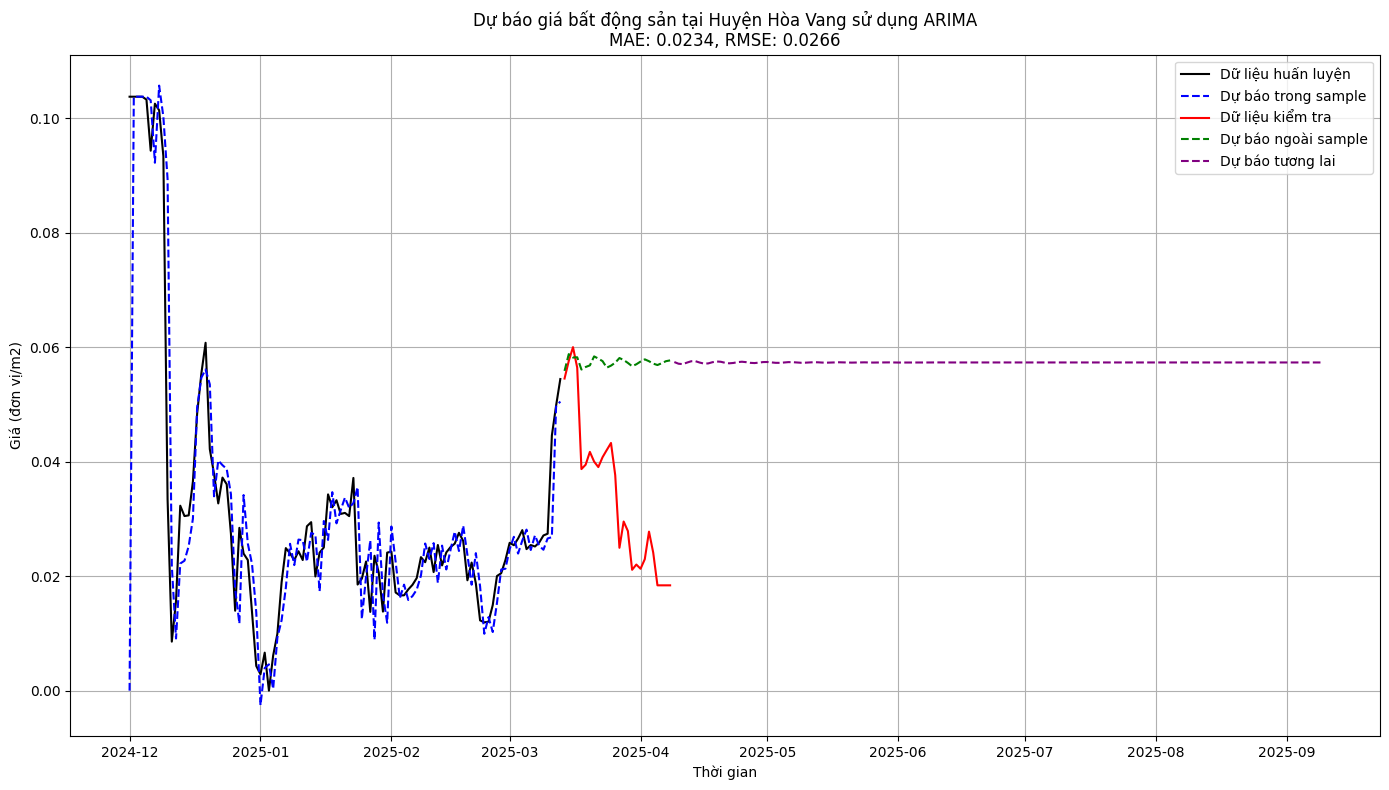

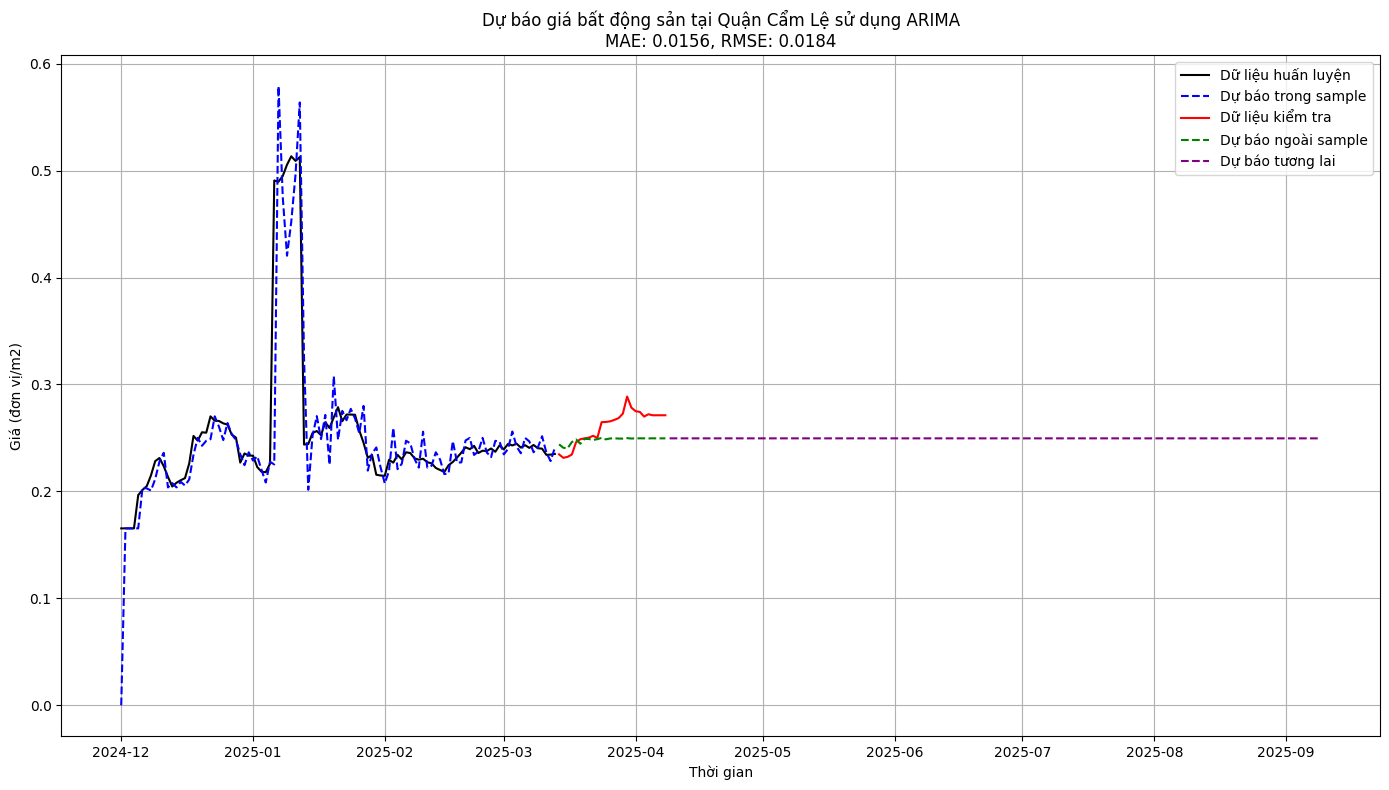

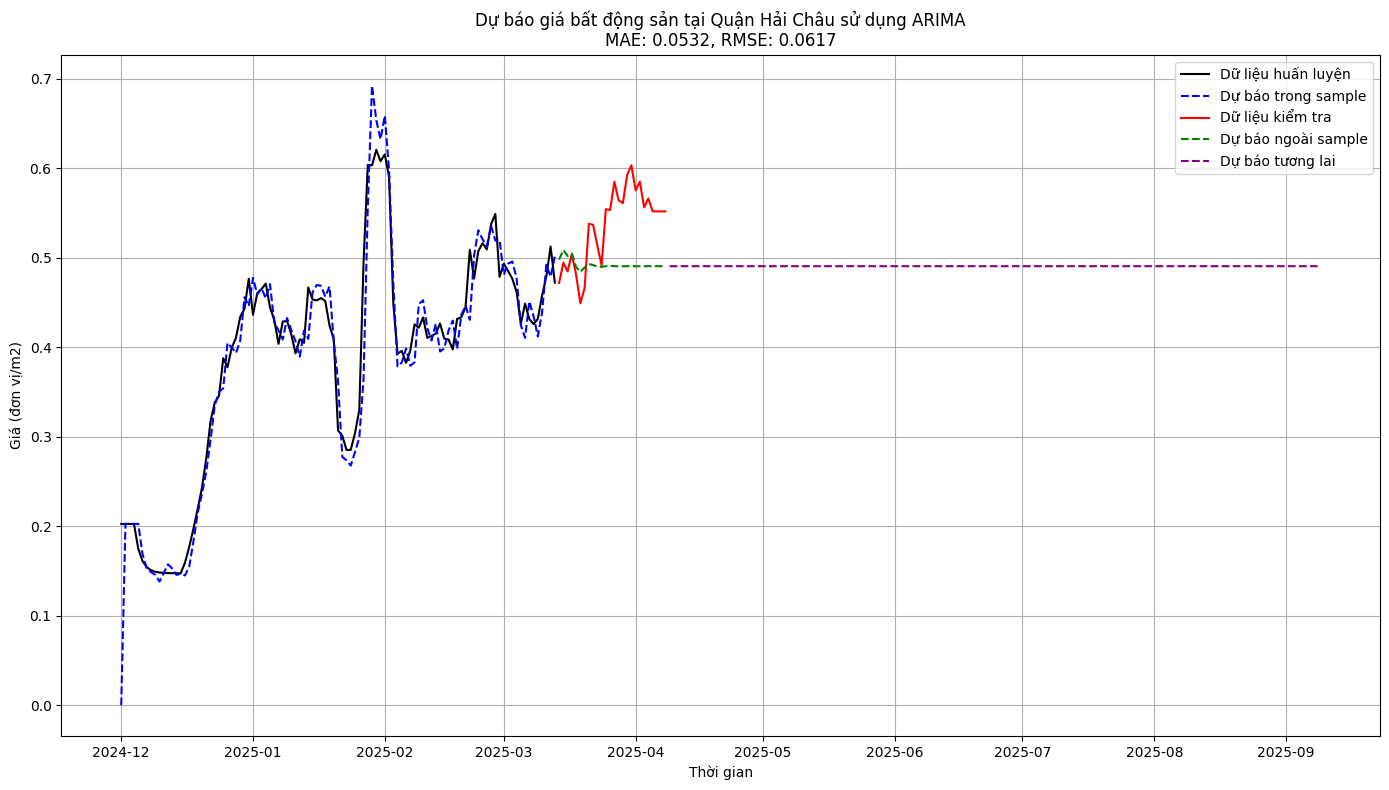

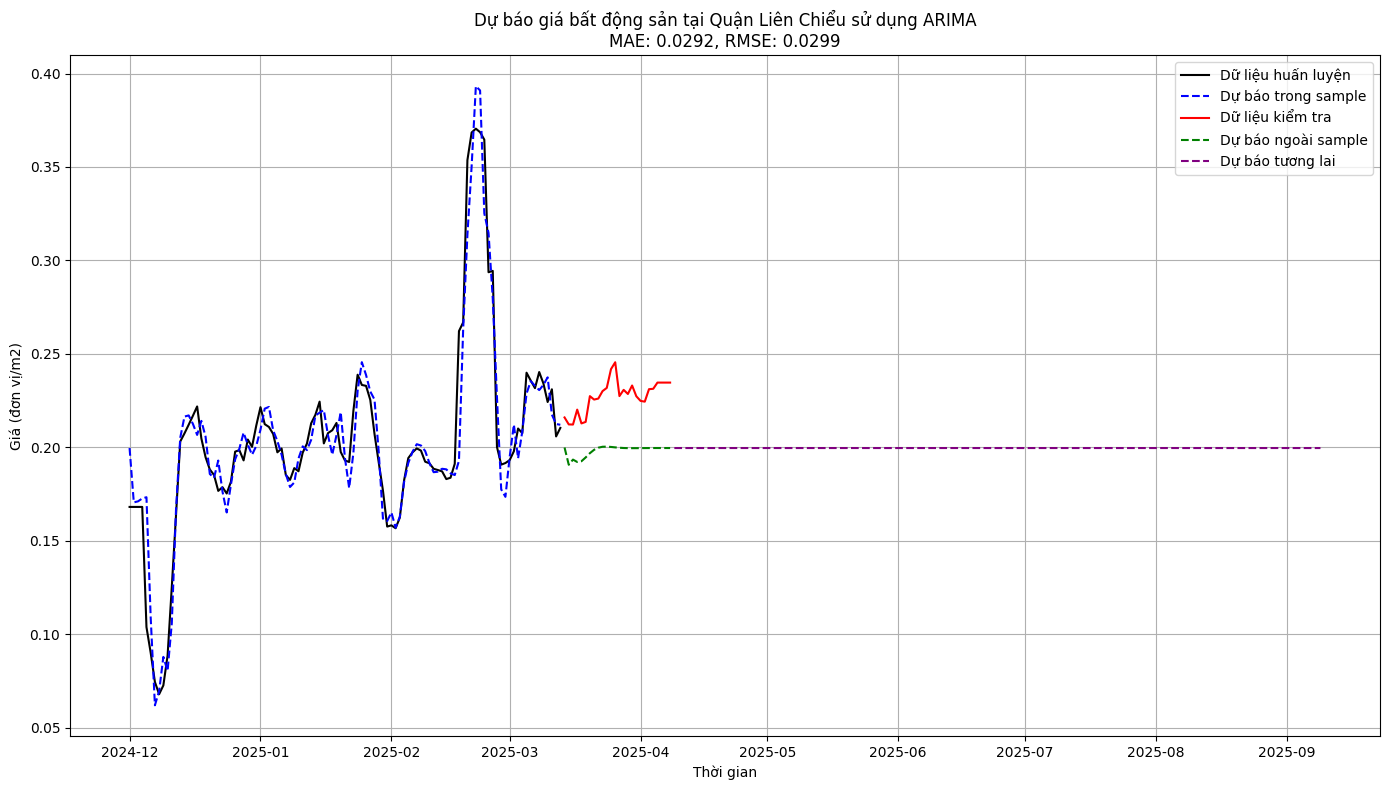

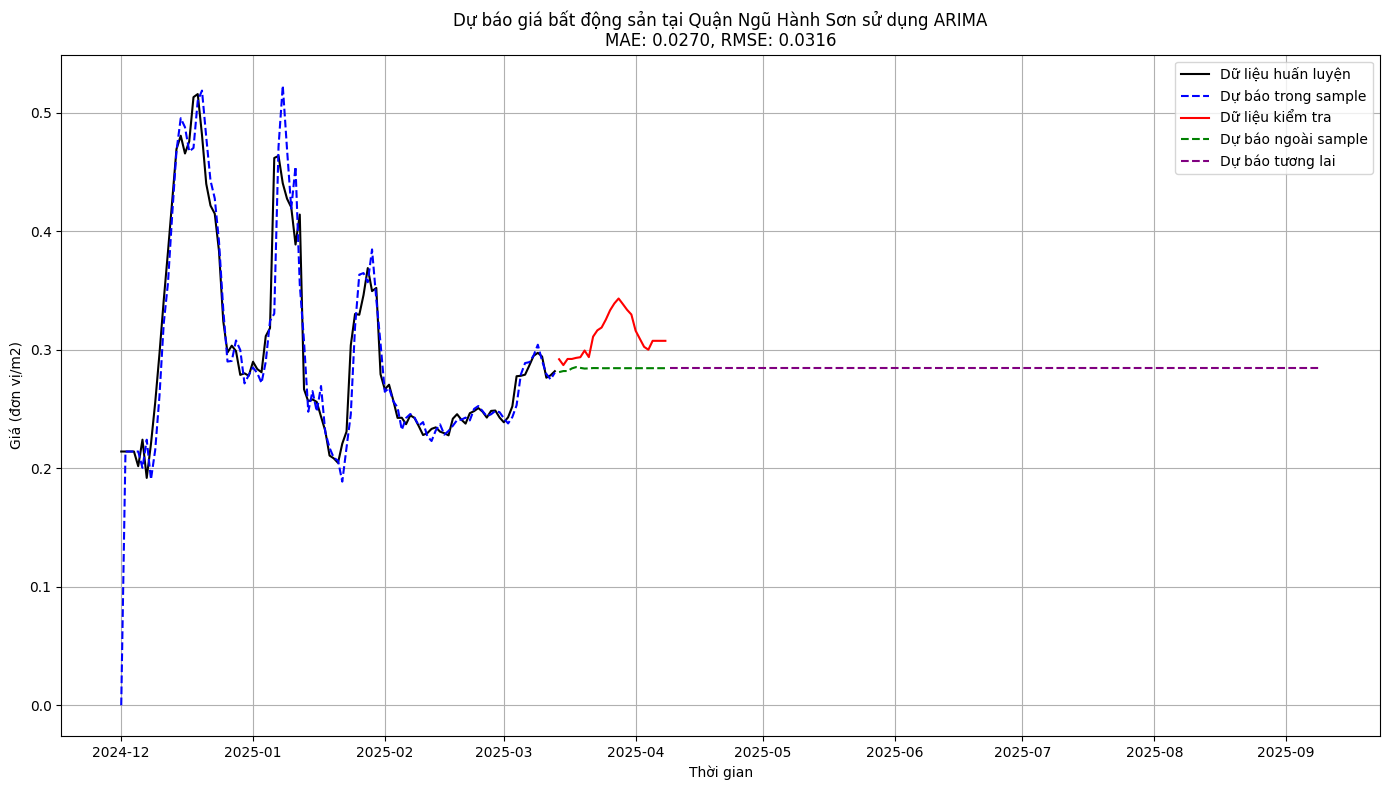

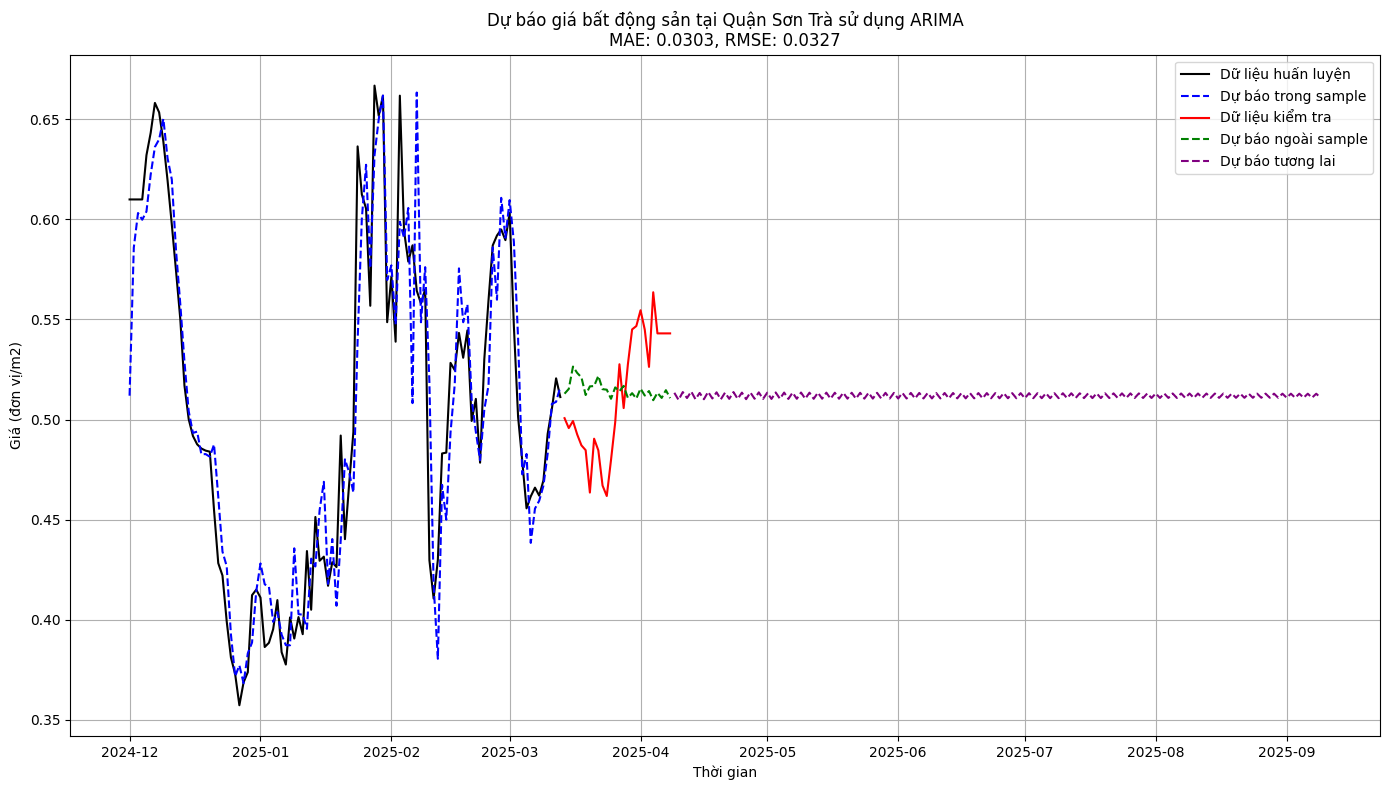

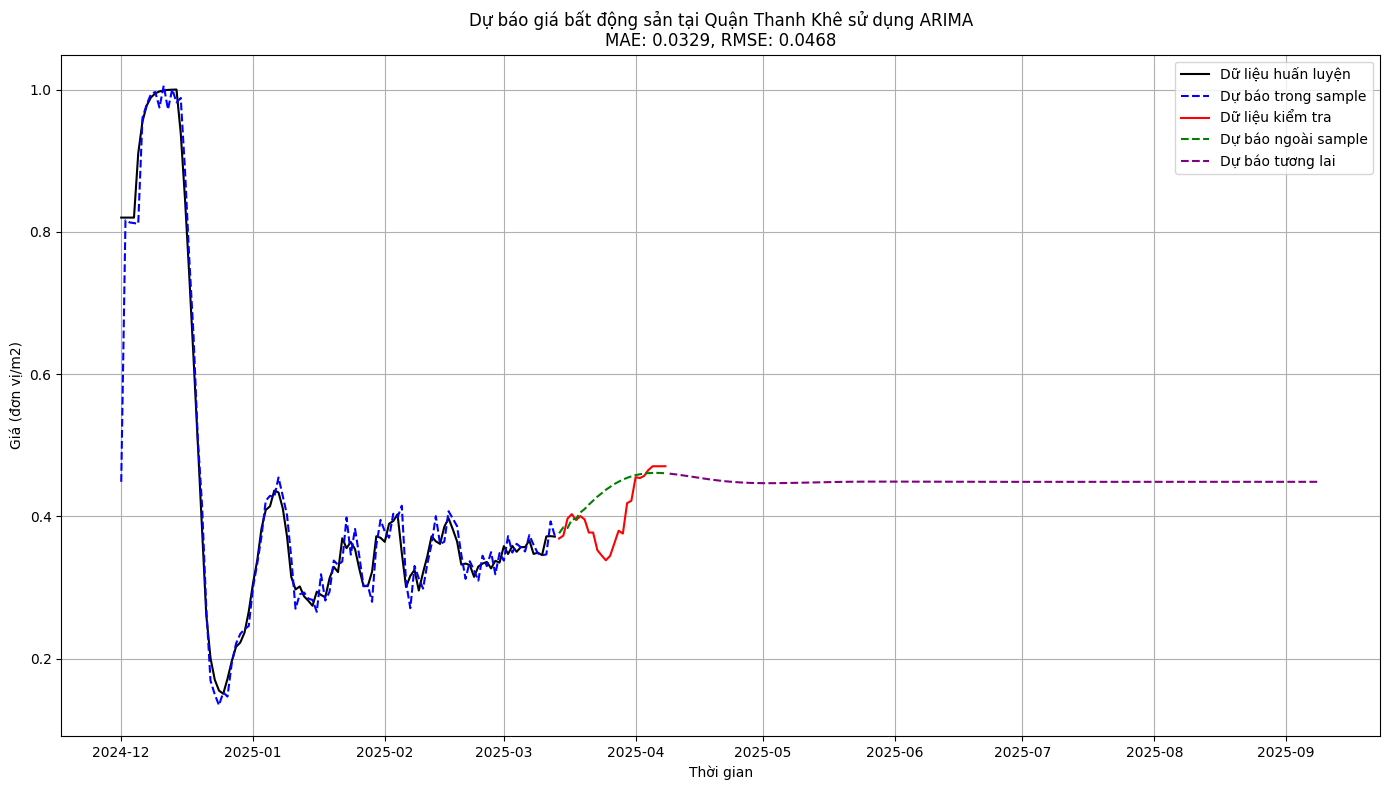

In [15]:
# Bước 14: Vẽ biểu đồ cho từng quận
for district in districts:
    if district in evaluation_results:
        plot_district_forecast(
            district, 
            evaluation_results[district],
            district_datasets[district]
        ).show()

In [16]:
# Bước 15: Dự báo giá trong một khoảng thời gian cho quận cụ thể
def forecast_district_range(district, model_info, start_date, end_date):
    """
    Dự báo giá cho một quận trong một khoảng thời gian cụ thể
    
    Parameters:
    district (str): Tên quận
    model_info (dict): Thông tin về mô hình ARIMA
    start_date (str): Ngày bắt đầu (định dạng 'YYYY-MM-DD')
    end_date (str): Ngày kết thúc (định dạng 'YYYY-MM-DD')
    
    Returns:
    DataFrame: Kết quả dự báo trong khoảng thời gian
    """
    # Chuyển đổi sang datetime
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Tính số ngày cần dự báo
    days = (end - start).days + 1
    
    # Lấy mô hình
    model_results = model_info['model']
    
    # Dự báo
    forecast = model_results.forecast(steps=days)
    
    # Tạo dataframe kết quả
    dates = pd.date_range(start=start, end=end)
    result_df = pd.DataFrame({
        'Ngày': dates,
        'Giá dự báo': forecast[:len(dates)]
    })
    
    # Tính khoảng tin cậy 95% (đây là ước lượng đơn giản)
    forecast_stderr = np.sqrt(model_results.params['sigma2'])
    result_df['Giá thấp nhất (95%)'] = result_df['Giá dự báo'] - 1.96 * forecast_stderr
    result_df['Giá cao nhất (95%)'] = result_df['Giá dự báo'] + 1.96 * forecast_stderr
    
    return result_df

In [17]:
# Bước 16: Ứng dụng: Dự báo giá cho một quận cụ thể trong khoảng thời gian
selected_district = districts[0]  # Thay đổi theo quận bạn muốn dự báo
start_date = '2025-01-01'         # Thay đổi theo nhu cầu
end_date = '2025-03-31'           # Thay đổi theo nhu cầu

forecast_result = forecast_district_range(
    selected_district,
    district_models[selected_district],
    start_date,
    end_date
)

print(f"Dự báo giá cho {selected_district} từ {start_date} đến {end_date}:")
forecast_result.head(10)  # Hiển thị 10 ngày đầu tiên

Dự báo giá cho Huyện Hòa Vang từ 2025-01-01 đến 2025-03-31:


,Ngày,Giá dự báo,Giá thấp nhất (95%),Giá cao nhất (95%)
2025-03-14,2025-01-01,0.055845,0.040159,0.071530
2025-03-15,2025-01-02,0.058770,0.043085,0.074455
2025-03-16,2025-01-03,0.058177,0.042491,0.073862
2025-03-17,2025-01-04,0.058224,0.042539,0.073909
2025-03-18,2025-01-05,0.056079,0.040394,0.071765
2025-03-19,2025-01-06,0.056525,0.040840,0.072210
2025-03-20,2025-01-07,0.056805,0.041120,0.072490
2025-03-21,2025-01-08,0.058376,0.042691,0.074061
2025-03-22,2025-01-09,0.057995,0.042309,0.073680
2025-03-23,2025-01-10,0.057549,0.041864,0.073234


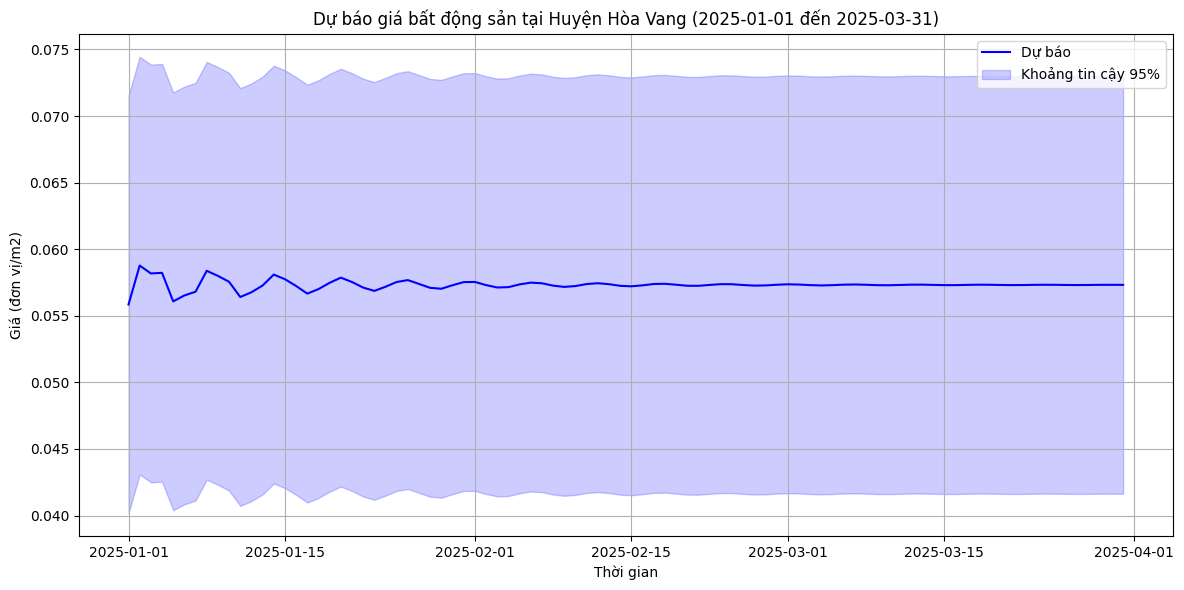

In [18]:
# Bước 17: Vẽ biểu đồ dự báo trong khoảng thời gian
plt.figure(figsize=(12, 6))
plt.plot(forecast_result['Ngày'], forecast_result['Giá dự báo'], color='blue', label='Dự báo')
plt.fill_between(
    forecast_result['Ngày'],
    forecast_result['Giá thấp nhất (95%)'],
    forecast_result['Giá cao nhất (95%)'],
    color='blue',
    alpha=0.2,
    label='Khoảng tin cậy 95%'
)

plt.title(f'Dự báo giá bất động sản tại {selected_district} ({start_date} đến {end_date})')
plt.xlabel('Thời gian')
plt.ylabel('Giá (đơn vị/m2)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Bước 18: Tạo hàm dự báo cho tất cả các quận trong một khoảng thời gian
def forecast_all_districts(models, start_date, end_date):
    """
    Dự báo giá cho tất cả các quận trong một khoảng thời gian
    
    Parameters:
    models (dict): Dictionary chứa các mô hình đã huấn luyện
    start_date (str): Ngày bắt đầu (định dạng 'YYYY-MM-DD')
    end_date (str): Ngày kết thúc (định dạng 'YYYY-MM-DD')
    
    Returns:
    dict: Kết quả dự báo cho từng quận
    """
    results = {}
    
    for district, model_info in models.items():
        results[district] = forecast_district_range(
            district, model_info, start_date, end_date
        )
    
    return results

In [20]:
# Bước 19: Dự báo cho tất cả quận
all_forecasts = forecast_all_districts(district_models, start_date, end_date)

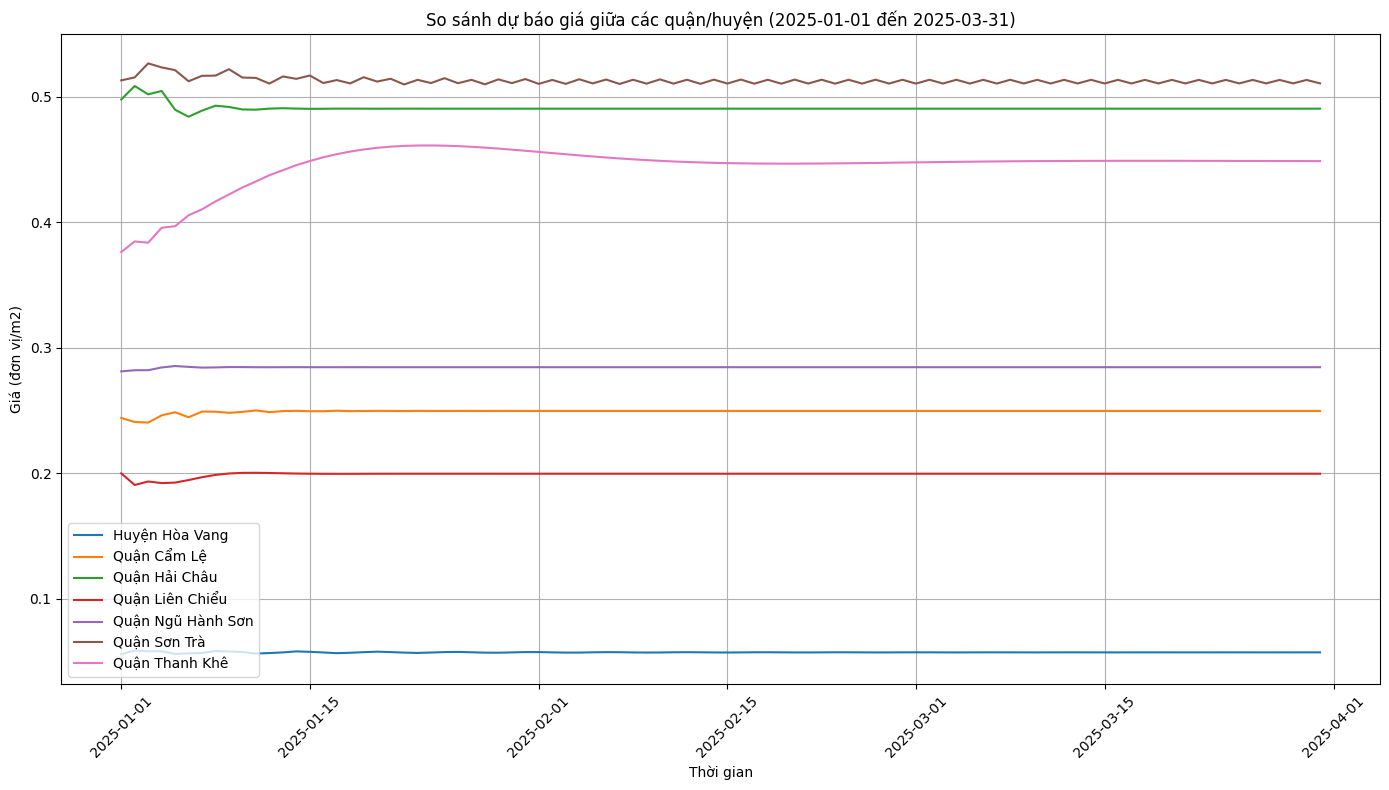

In [21]:
# Bước 20: So sánh dự báo giữa các quận
plt.figure(figsize=(14, 8))

for district, forecast_df in all_forecasts.items():
    plt.plot(forecast_df['Ngày'], forecast_df['Giá dự báo'], label=district)

plt.title(f'So sánh dự báo giá giữa các quận/huyện ({start_date} đến {end_date})')
plt.xlabel('Thời gian')
plt.ylabel('Giá (đơn vị/m2)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Bước 22: Lưu mô hình để sử dụng sau này (tùy chọn)
import pickle

# Lưu các mô hình
with open('district_arima_models.pkl', 'wb') as f:
    pickle.dump(district_models, f)

print("Đã lưu mô hình thành công")

Đã lưu mô hình thành công


So sánh hiệu suất các mô hình:
            District       MAE       MSE      RMSE ARIMA_order
0     Huyện Hòa Vang  0.023391  0.000707  0.026598     (3,1,4)
1        Quận Cẩm Lệ  0.015612  0.000337  0.018356     (4,1,5)
2      Quận Hải Châu  0.053250  0.003809  0.061718     (2,1,5)
3    Quận Liên Chiểu  0.029160  0.000896  0.029925     (2,0,5)
4  Quận Ngũ Hành Sơn  0.027028  0.000997  0.031569     (2,1,5)
5       Quận Sơn Trà  0.030276  0.001067  0.032672     (5,0,3)
6     Quận Thanh Khê  0.032937  0.002194  0.046839     (5,0,2)


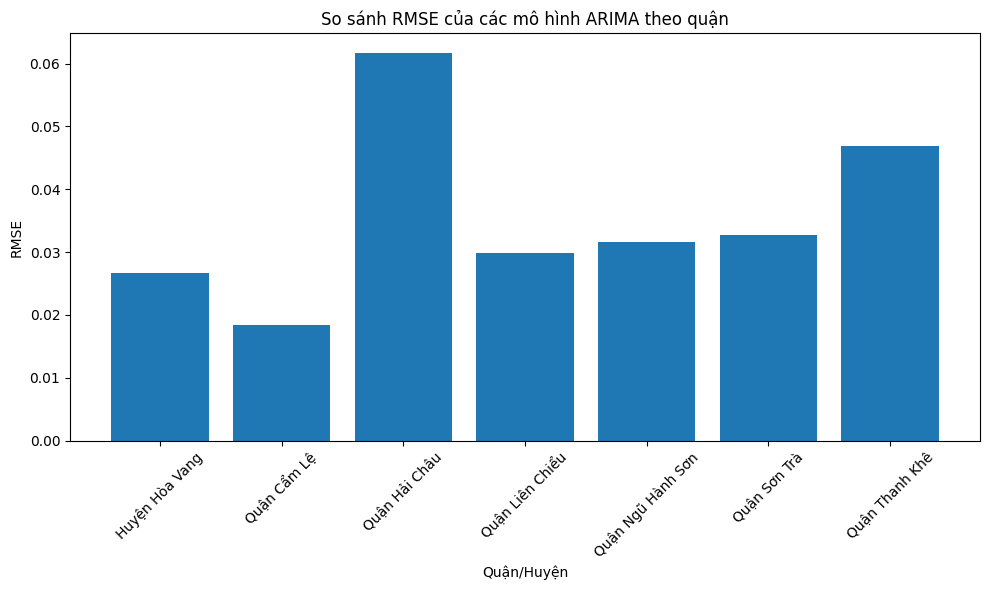

In [27]:
# Bước 23: So sánh hiệu suất các mô hình qua các quận
# Tạo danh sách lưu từng dòng kết quả
evaluation_rows = []

for district, eval_result in evaluation_results.items():
    metrics = eval_result['test_metrics']
    order = district_models[district]['order']
    
    evaluation_rows.append({
        'District': district,
        'MAE': metrics['mae'],
        'MSE': metrics['mse'],
        'RMSE': metrics['rmse'],
        'ARIMA_order': f"({order[0]},{order[1]},{order[2]})"
    })

# Tạo DataFrame từ danh sách
evaluation_df = pd.DataFrame(evaluation_rows)

# Hiển thị kết quả
print("So sánh hiệu suất các mô hình:")
print(evaluation_df)

# Vẽ biểu đồ so sánh RMSE
plt.figure(figsize=(10, 6))
plt.bar(evaluation_df['District'], evaluation_df['RMSE'])
plt.title('So sánh RMSE của các mô hình ARIMA theo quận')
plt.xlabel('Quận/Huyện')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
# Bước 24: Hàm tiện ích để dự báo nhanh trong tương lai
def quick_forecast(district, date, models):
    """
    Dự báo nhanh giá cho một quận vào một ngày cụ thể
    
    Parameters:
    district (str): Tên quận
    date (str): Ngày cần dự báo, định dạng 'YYYY-MM-DD'
    models (dict): Dictionary chứa các mô hình đã huấn luyện
    
    Returns:
    dict: Kết quả dự báo
    """
    if district not in models:
        print(f"Không tìm thấy mô hình cho {district}")
        return None
    
    try:
        date_obj = pd.to_datetime(date)
        model_info = models[district]
        model_results = model_info['model']
        
        # Tính số ngày cần dự báo từ cuối tập huấn luyện
        train_end_date = model_results.data.dates[-1]
        days_ahead = (date_obj - train_end_date).days
        
        if days_ahead <= 0:
            print(f"Ngày dự báo phải sau ngày cuối cùng của tập huấn luyện: {train_end_date}")
            return None
        
        # Dự báo
        forecast = model_results.forecast(steps=days_ahead)
        predicted_price = forecast[-1]
        
        # Tính khoảng tin cậy
        forecast_stderr = np.sqrt(model_results.params['sigma2'])
        lower_bound = predicted_price - 1.96 * forecast_stderr
        upper_bound = predicted_price + 1.96 * forecast_stderr
        return {
            'date': date,
            'district': district,
            'predicted_price': predicted_price,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

    except Exception as e:
        print(f"Lỗi khi dự báo cho {district} vào ngày {date}: {e}")
        return None
